In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from pymbar import timeseries as ts

# Analysis saltswap results
## Applied chemical potential: $\Delta\mu = 750$

Defining a functions to read the simulation data, and generating pretty colours for plotting.

In [2]:
def read_data(filename):
    """
    Read the number of salt molecules added, acceptance rates, and simulation run times for iterations of saltswap
    
    Parameters
    ----------
    filename: str
      the name of the file that contains the simulation data
      
    Returns
    -------
    data: numpy.ndarray
      array containing number of waters, number of salt pairs, acceptance probability, and run-time per iteration
    """
    filelines = open(filename).readlines()
    Nwats = []
    Nsalt = []
    Accprob = []
    time = []
    #i=3
    #step = int(filelines[i][0:5].strip())
    #while i-3 == step:
    #while i > 0:
    for i in range(3,len(filelines)-3):
        # It appears some of the files have a varying length. This exception will pick those up.
        try:
            dummy = int(filelines[i][6:10].strip())
        except ValueError:
            break
        Nwats.append(int(filelines[i][6:10].strip()))
        Nsalt.append(int(filelines[i][13:18].strip()))
        #print 'nsalt', int(filelines[i][13:18].strip())
        Accprob.append(float(filelines[i][19:24].strip()))
        #print 'acc', filelines[i][19:24].strip()
        time.append(int(filelines[i][35:40].strip()))
        #print 'time', filelines[i][35:40].strip()
        #i += 1
    return np.vstack((np.array(Nwats),np.array(Nsalt),np.array(Accprob),np.array(time)))

def read_work(filename):
    """
    Function to read the work to add or remove salt in a saltswap simulation.
    
    Parameter
    ---------
    filename: str
      the name of the file containing the work for each attempt
      
    Returns
    -------
    work: numpy.ndarray
      array of work values
    """
    filelines = open(filename).readlines()
    work = []
    for i in range(2,len(filelines)):
        work += [float(wrk) for wrk in filelines[i].split()]
    return np.array(work)    


# Nice colours, taken on 26th Nov 2015 from:
#http://tableaufriction.blogspot.co.uk/2012/11/finally-you-can-use-tableau-data-colors.html

# These are the "Tableau" colors as RGB. I've chosen my faves. 
# In order: blue, green, purple, orange. Hopefully a good compromise for colour-blind people.
tableau4 = [(31, 119, 180),(44, 160, 44),(148,103,189),(255, 127, 14)]
tableau4_light = [(174,199,232),(152,223,138),(197,176,213),(255,187,120)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts. 
for i in range(len(tableau4)):    
    r, g, b = tableau4[i]    
    tableau4[i] = (r / 255., g / 255., b / 255.)
    r, g, b = tableau4_light[i]    
    tableau4_light[i] = (r / 255., g / 255., b / 255.)

<a id='summary'></a>
## NCMC parameter sweep at a glance
Plotting colored matrices to summarise the main results.

/Users/rossg/miniconda2/lib/python2.7/site-packages/matplotlib/tight_layout.py:222: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


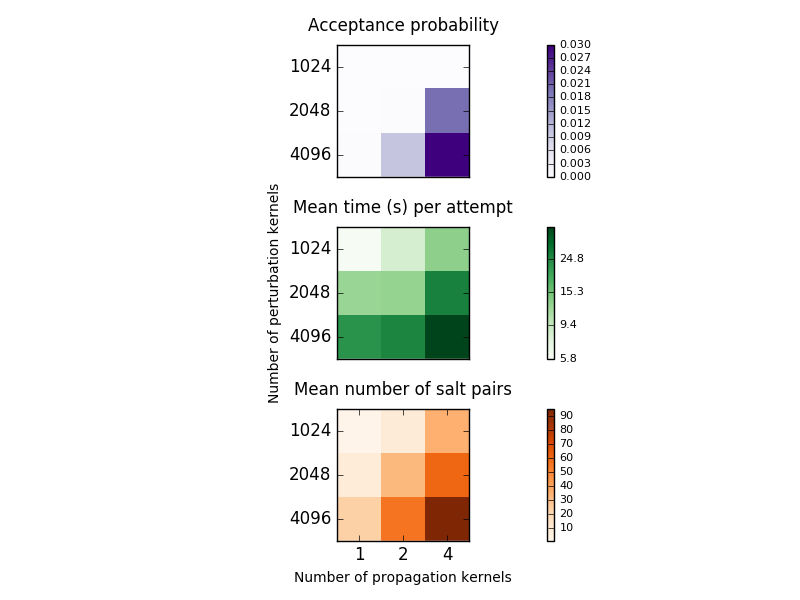

In [3]:
# Results from the initial set of parameters:
nperturbations = [1024,2048,4096]
npropogations = [1,2,4]

MeanSalt = np.zeros((len(nperturbations),len(npropogations)))
AccProb = np.zeros((len(nperturbations),len(npropogations)))
MeanTime = np.zeros((len(nperturbations),len(npropogations)))

for i in range(len(nperturbations)):
    for j in range(len(npropogations)):
        filename = 'Titration750/prt{0}_prp{1}/data.txt'.format(nperturbations[i],npropogations[j])
        data = read_data(filename)
        MeanSalt[i,j] = data[1].mean()     # The recorded times are for 10 insertion attempts 
        AccProb[i,j] = data[2].mean()
        MeanTime[i,j] = data[3].mean()/20

fig,ax = plt.subplots(nrows=3,ncols=1,squeeze=True)

# Acceptance probability
cax = ax[0].matshow(np.round(AccProb,2),cmap=plt.cm.Purples,interpolation='none')
c = fig.colorbar(cax,ax=ax[0])
c.ax.tick_params(labelsize=8) 
ax[0].get_xaxis().set_visible(False)
ax[0].set_yticklabels(['']+nperturbations)
ax[0].set_title('Acceptance probability',fontsize=12)

# Mean time per attempt on log scale
logtimes = np.log10(MeanTime)
lt = np.arange(np.min(logtimes),np.max(logtimes),0.21)
ticks = np.round(10**lt,1)
cax = ax[1].matshow(logtimes,cmap=plt.cm.Greens,interpolation='none')
c = fig.colorbar(cax,ticks=lt,ax=ax[1])
c.set_ticklabels(ticks, update_ticks=True)
c.ax.tick_params(labelsize=8) 
ax[1].set_xticklabels(['']+npropogations)
ax[1].get_xaxis().set_visible(False)
#ax[1].xaxis.set_tick_params(labelbottom='on',labeltop='off')
ax[1].set_yticklabels(['']+nperturbations)
ax[1].set_title('Mean time (s) per attempt',fontsize=12)
ax[1].set_ylabel("Number of perturbation kernels",fontsize=10)   

# Mean number of salt pairs to test consistency
cax = ax[2].matshow(MeanSalt,cmap=plt.cm.Oranges,interpolation='none')
c = fig.colorbar(cax)
c.ax.tick_params(labelsize=8) 
ax[2].set_xticklabels(['']+npropogations)
ax[2].xaxis.set_tick_params(labelbottom='on',labeltop='off')
ax[2].set_yticklabels(['']+nperturbations)
ax[2].set_title('Mean number of salt pairs',fontsize=12)
ax[2].set_xlabel("Number of propagation kernels",fontsize=10)    
ax[2].xaxis.set_label_position('bottom') 
#(h_pad=-1,w_pad=-100)
plt.tight_layout(h_pad=-1,rect=(-1,0,1,1)) # rect = (left, bottom, right, top)
plt.savefig("ParamSweep1.png", format='png')
Image("ParamSweep1.png",width=1200)

The data does not seem equilibrated.

## Time series plots
Viewing to what extent the data can be considered to be 'in equilibrium'.

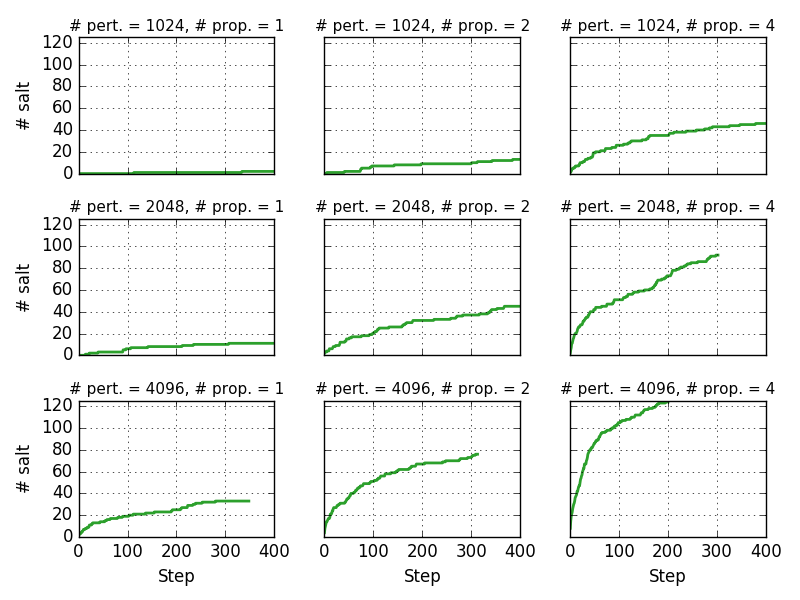

In [24]:
params = [(1024,1),(1024,2),(1024,4),(2048,1),(2048,2),(2048,4),(4096,1),(4096,2),(4096,4)]
coords = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2),(2,0),(2,1),(2,2)]

f, axarr = plt.subplots(3, 3)
xlims =(0,400)       # x limits
ylims = (0,125)       # y limits
xstep = 100

for p,c in zip(params,coords):
    # Reading in data
    filename = 'Titration750/prt{0}_prp{1}/data.txt'.format(p[0],p[1])
    nsalt = read_data(filename)[1]
    #time = np.arange(1,len(nsalt)+1) 
    time = range(len(nsalt))
    # Plotting
    axarr[c].plot(nsalt,color=tableau4[1],linewidth=2)
    axarr[c].set_xlim(xlims)
    axarr[c].set_ylim(ylims)
    axarr[c].set_ylim(ylims)
    axarr[c].set_title('# pert. = {0}, # prop. = {1}'.format(p[0],p[1]),fontsize=11)
    axarr[c].set_xticks(np.arange(xlims[0], xlims[1]+xstep, xstep))
    axarr[c].grid()
    #try:
    #    stats = ts.detectEquilibration(nsalt) # Start of equil time, stat inefficiency, num uncorrelated sample
    #    axarr[c].axvline(x=stats[0],linewidth=2, color='k')
    #except ts.ParameterError:
    #    pass
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
plt.setp([a.get_xticklabels() for a in axarr[1, :]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False) 
plt.setp([a.get_yticklabels() for a in axarr[:, 2]], visible=False)  
for a in axarr[2, :]: a.set_xlabel('Step') 
for a in axarr[:,0]: a.set_ylabel('# salt') 


plt.tight_layout()
plt.savefig("TimeSeries.png", format='png')
Image("TimeSeries.png")

None of the simulations reach equilibrium, and it's worrying that the steady state appears to be the formation of a salt crystal.

## Work distributions
### # perturbations = 4096, # propagations = 4 
Looking at # perturbations = 4096, # propagations = 4 as it's the most computationally expensive protocol.

In [5]:
kT = 2.479
print 'Chemical potential in units of kT =', 750/kT

Chemical potential in units of kT = 302.541347317


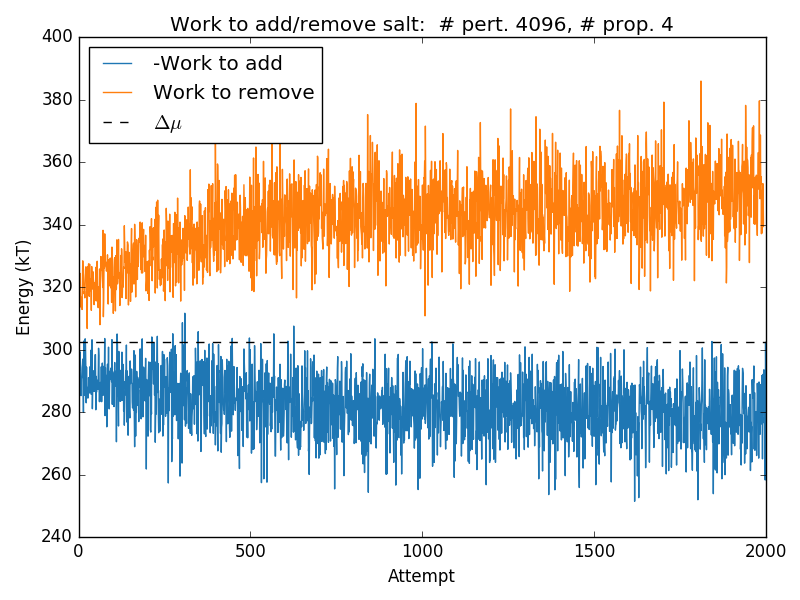

In [50]:
work_add = read_work('Titration750/prt4096_prp4/work_add_data.txt')
work_rm = read_work('Titration750/prt4096_prp4/work_rm_data.txt')


plt.clf()
plt.plot(-work_add, color=tableau4[0])
plt.plot(work_rm, color=tableau4[3])
plt.axhline(750/kT, ls='--', color='k')

plt.title('Work to add/remove salt:  # pert. 4096, # prop. 4')
plt.legend(('-Work to add','Work to remove','$\Delta \mu$'),loc=0)
plt.xlabel('Attempt')
plt.ylabel('Energy (kT)')
plt.xlim((0,2000))

plt.savefig('Work_prt4096_prp4.png',format='png')
Image('Work_prt4096_prp4.png')

The work to remove salt increases are more salt is added to the system. This is the opposite of what we want, as this incourages more salt to enter the system.

### How Work decreases with longer protocol
Given the increase in salt pairs over time, I'll only look at the work distributions for the first 500 insertion/deletion attempts.

In [64]:
params = [(1024,1),(2048,1),(4096,1)]

N = 500
work_add = np.zeros((3,N))
work_rm = np.zeros((3,N))

for i in range(len(params)):
    filename = 'Titration750/prt{0}_prp{1}/work_add_data.txt'.format(params[i][0],params[i][1])
    work_add[i,:] = read_work(filename)[0:N]
    filename = 'Titration750/prt{0}_prp{1}/work_rm_data.txt'.format(params[i][0],params[i][1])
    work_rm[i,:] = read_work(filename)[0:N]

### Histogram of work to add salt

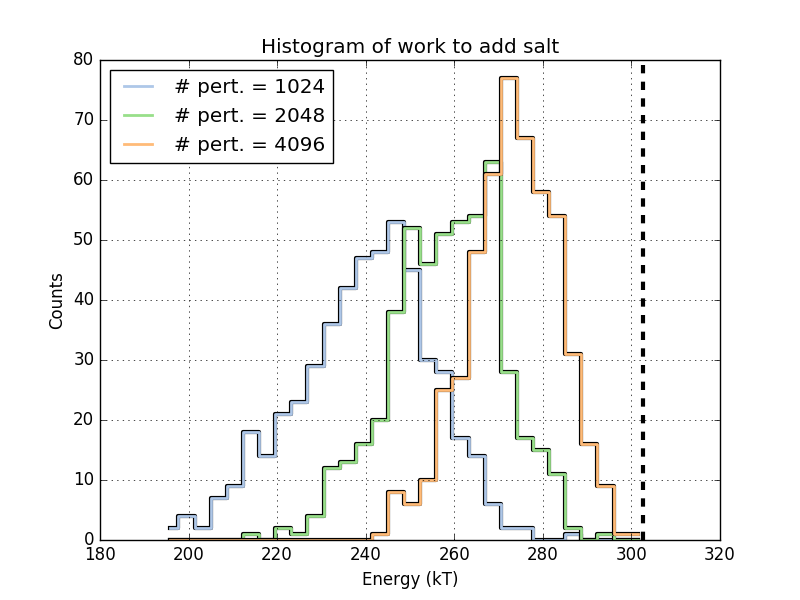

In [106]:
# Automatically calculate the histogram of all the data, and save the edges and midpoints
counts, edges = np.histogram(-work_add,30)
midpoints =  edges[0:-1] + np.diff(edges)/2.0

colours = (tableau4_light[0], tableau4_light[1], tableau4_light[3])
plt.clf()
lines = []
for i in range(3):
    cnts, junk = np.histogram(a = -work_add[i,:], bins = edges)
    plt.step(midpoints, cnts, where='mid',color='k', lw = 3)
    lines.append(plt.step(midpoints, cnts, where='mid', color=colours[i], lw = 2, label = '# pert. = {0}'.format(params[i][0])))
plt.axvline(750/kT, ls='--', color='k',lw=3)    

plt.legend(loc=0)
plt.title('Histogram of work to add salt')
plt.ylabel('Counts')
plt.xlabel('Energy (kT)')
plt.grid()
plt.savefig(filename="Hist_Work_Add.png")
Image(filename="Hist_Work_Add.png")

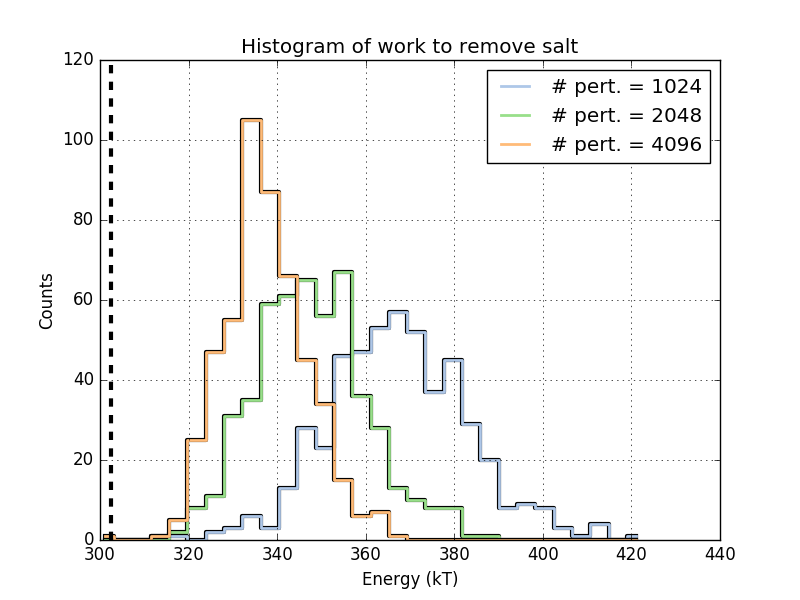

In [104]:
# Automatically calculate the histogram of all the data, and save the edges and midpoints
counts, edges = np.histogram(work_rm,30)
midpoints =  edges[0:-1] + np.diff(edges)/2.0

colours = (tableau4_light[0], tableau4_light[1], tableau4_light[3])
plt.clf()
lines = []
for i in range(3):
    cnts, junk = np.histogram(a = work_rm[i,:], bins = edges)
    plt.step(midpoints, cnts, where='mid',color='k', lw = 3)
    lines.append(plt.step(midpoints, cnts, where='mid', color=colours[i], lw = 2, label = '# pert. = {0}'.format(params[i][0])))
plt.axvline(750/kT, ls='--', color='k',lw=3)    

plt.legend(loc=0)
plt.title('Histogram of work to remove salt')
plt.ylabel('Counts')
plt.xlabel('Energy (kT)')
plt.grid()
plt.savefig(filename="Hist_Work_Rm.png")
Image(filename="Hist_Work_Rm.png")

The location and spread of the work decreases as the length of the protocol decreases.